In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DF_for_ml/2025_11_26_eda_final_ecg_data.csv', low_memory=False)

In [ ]:
categorical_columns = ['heart_axis_norm', 'V1_pathological_Q']
numeric_columns = ['age', 'I_prop_censored', 'II_wavelet_entropy', 'II_SNR_dB', 'III_PSD_std_freq', 'III_wavelet_E2', 'AVR_RMSSD', 'AVR_STFT_energy', 'AVR_SNR_dB', 'AVR_prop_censored', 'AVL_STFT_energy', 'AVL_SNR_dB', 'AVF_SNR_dB', 'V1_RMSSD', 'V1_STFT_energy', 'V1_wavelet_entropy', 'V1_SNR_dB', 'V2_STFT_energy', 'V2_SNR_dB', 'V2_Q_wave_amp', 'V3_STFT_energy', 'V3_SNR_dB', 'V3_Q_wave_amp', 'V4_STFT_energy', 'V4_SNR_dB', 'V5_SNR_dB', 'V5_prop_censored', 'V5_Q_wave_amp', 'V6_STFT_energy', 'V6_SNR_dB', 'V6_prop_censored', 'meanRR_global', 'V3_PSD_mean_freq', 'V5_PSD_std_freq', 'AVF_wavelet_E5', 'I_wavelet_E5', 'I_wavelet_entropy']
target_columns = ['target_norm', 'target_arrhythmia', 'target_infarction']

In [ ]:
X = df.drop(columns=target_columns)
y = df['target_norm']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train[numeric_columns])
X_test_numeric_scaled = scaler.transform(X_test[numeric_columns])
X_train_scaled = np.hstack([X_train_numeric_scaled, X_train[categorical_columns]])
X_test_scaled = np.hstack([X_test_numeric_scaled, X_test[categorical_columns]])

Главное в модели - минимизировать ложноотрицательные прогнозы.

Рассматриваем 2 функции потерь:

1. Log Loss (default) - Считает все ошибки одинаково.

2. Log Loss с class_weight='balanced' - увеличивает вес всего класса 0 (больное ЭКГ).

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import fbeta_score, make_scorer, confusion_matrix, recall_score, precision_score


param_grid = {
    'class_weight': [
        {0: 1, 1: 1},      # сбалансированный
        {0: 1.5, 1: 1},    # легкий перевес больных
        {0: 2, 1: 1},      # умеренный перевес больных
        {0: 3, 1: 1},      # сильный перевес больных
        {0: 4, 1: 1},      # очень сильный перевес больных
        {0: 5, 1: 1},      # экстремальный перевес больных
        'balanced',         # автоматический баланс
        {0: 2, 1: 0.8},    # сложное соотношение
        {0: 3, 1: 0.7}     # сложное соотношение 2
    ],
    'C': [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10],
    'solver': ['liblinear', 'lbfgs', 'newton-cg'],
    'penalty': ['l2', 'l1'],
    'max_iter': [2000],
    'tol': [1e-3, 1e-4]
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


#Пробуем разные beta
beta_values = [1, 1.5, 2, 2.5, 3, 3.5, 4]

df_result = pd.DataFrame(columns=['beta', 'best_fbeta', 'precision', 'recall', 'fp', 'tp', 'fn', 'tn'])
trained_models = {}  #Словарь для сохранения моделей
for beta in beta_values:

    fbeta_scorer = make_scorer(fbeta_score, beta=beta, pos_label=0)
    grid_search = GridSearchCV(
        estimator=LogisticRegression(random_state=42),
        param_grid=param_grid,
        cv=cv,
        scoring=fbeta_scorer,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train_scaled, y_train)
    y_pred = grid_search.predict(X_test_scaled)

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    df_result.loc[len(df_result)] = {
        'beta': beta,
        'best_fbeta': grid_search.best_score_,
        'precision': precision_score(y_test, y_pred, pos_label=0),
        'recall': recall_score(y_test, y_pred, pos_label=0),
        'fp': fp,
        'tp': tp,
        'fn': fn,
        'tn': tn
    }
    trained_models[beta] = grid_search
print(df_result)

trained_models_for_norm = trained_models.copy()

# Сохраняем ВСЕ комбинации
df_result.to_csv('result.csv', index=False)


Fitting 10 folds for each of 864 candidates, totalling 8640 fits
Fitting 10 folds for each of 864 candidates, totalling 8640 fits
Fitting 10 folds for each of 864 candidates, totalling 8640 fits
Fitting 10 folds for each of 864 candidates, totalling 8640 fits
Fitting 10 folds for each of 864 candidates, totalling 8640 fits
Fitting 10 folds for each of 864 candidates, totalling 8640 fits
Fitting 10 folds for each of 864 candidates, totalling 8640 fits
   beta  best_fbeta  precision    recall   fp   tp   fn    tn
0   1.0    0.793533   0.708580  0.886216  123  484  394   958
1   1.5    0.835755   0.669583  0.920444   86  387  491   995
2   2.0    0.875102   0.645807  0.954672   49  312  566  1032
3   2.5    0.904457   0.598089  0.984274   17  163  715  1064
4   3.0    0.925925   0.598089  0.984274   17  163  715  1064
5   3.5    0.942831   0.562990  0.996300    4   42  836  1077
6   4.0    0.954733   0.562990  0.996300    4   42  836  1077


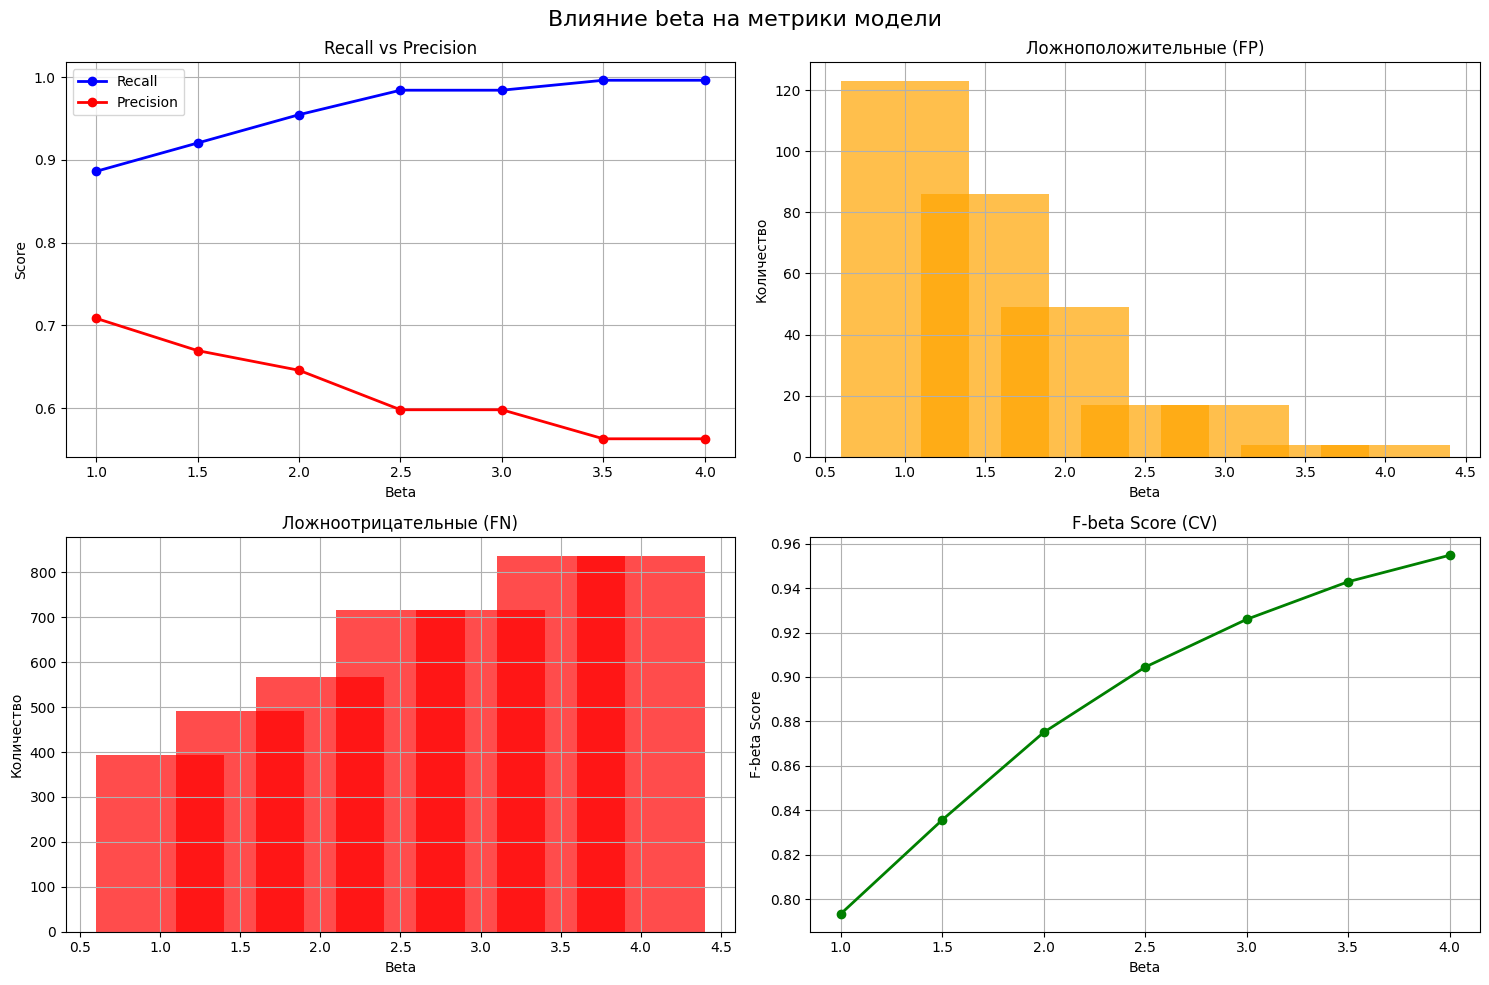

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Влияние beta на метрики модели', fontsize=16)

#Recall и Precision
axes[0, 0].plot(df_result['beta'], df_result['recall'], 'bo-', label='Recall', linewidth=2)
axes[0, 0].plot(df_result['beta'], df_result['precision'], 'ro-', label='Precision', linewidth=2)
axes[0, 0].set_xlabel('Beta')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Recall vs Precision')
axes[0, 0].legend()
axes[0, 0].grid(True)

#Ложные срабатывания
axes[0, 1].bar(df_result['beta'], df_result['fp'], color='orange', alpha=0.7)
axes[0, 1].set_xlabel('Beta')
axes[0, 1].set_ylabel('Количество')
axes[0, 1].set_title('Ложноположительные (FP)')
axes[0, 1].grid(True)

#Ложноотрицательные
axes[1, 0].bar(df_result['beta'], df_result['fn'], color='red', alpha=0.7)
axes[1, 0].set_xlabel('Beta')
axes[1, 0].set_ylabel('Количество')
axes[1, 0].set_title('Ложноотрицательные (FN)')
axes[1, 0].grid(True)

#F-beta score
axes[1, 1].plot(df_result['beta'], df_result['best_fbeta'], 'go-', linewidth=2)
axes[1, 1].set_xlabel('Beta')
axes[1, 1].set_ylabel('F-beta Score')
axes[1, 1].set_title('F-beta Score (CV)')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

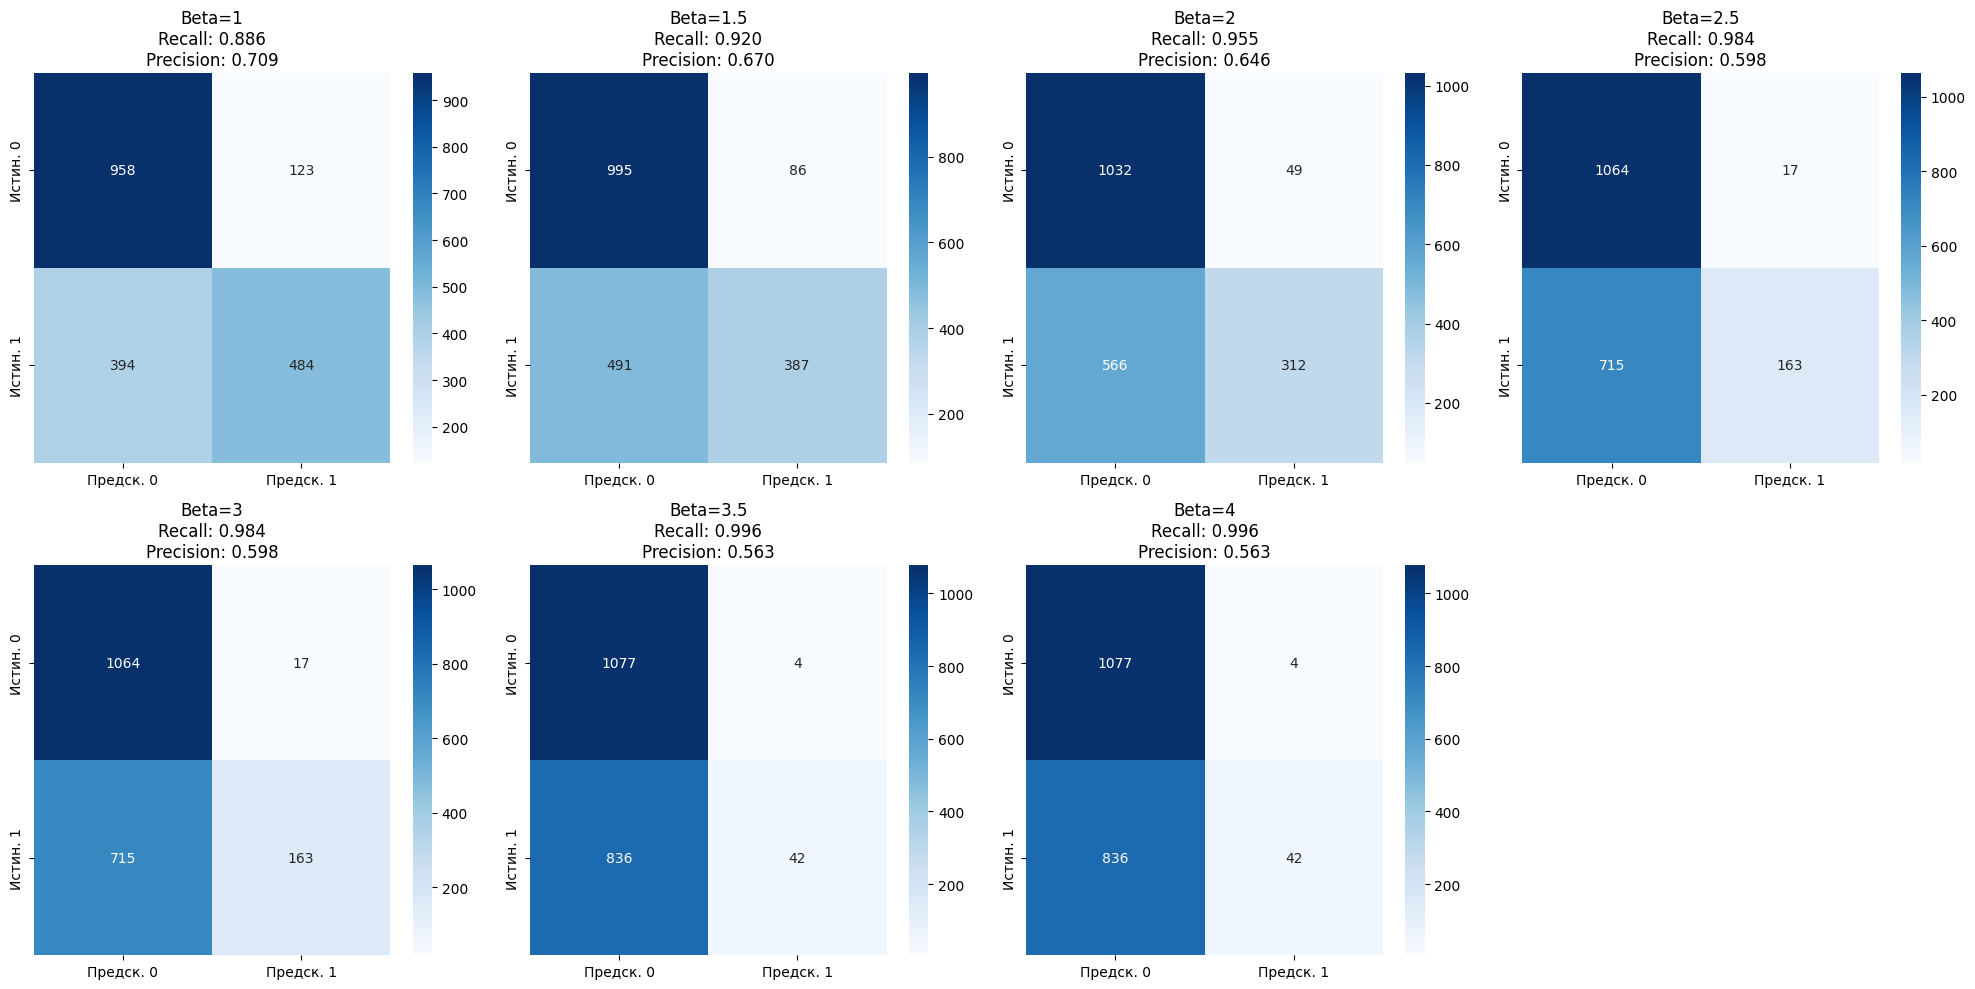

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, beta in enumerate(beta_values):
    model = trained_models[beta]
    y_pred = model.predict(X_test_scaled)

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Предск. 0', 'Предск. 1'],
                yticklabels=['Истин. 0', 'Истин. 1'])
    axes[i].set_title(f'Beta={beta}\nRecall: {df_result.loc[i, "recall"]:.3f}\nPrecision: {df_result.loc[i, "precision"]:.3f}')

if len(beta_values) < len(axes):
    for j in range(len(beta_values), len(axes)):
        axes[j].set_visible(False)

plt.tight_layout()
plt.show()

**Обоснование выбора beta=2.5**

Для задачи классификации ЭКГ на "норма/патология" выбрано значение beta=2.5 при оптимизации F-бета метрики. Данный параметр обеспечивает оптимальный баланс между клинической эффективностью и безопасностью пациентов.

**Ключевые преимущества beta=2.5:**
- **Максимальное обнаружение патологий** - recall 98.4% обеспечивает выявление практически всех случаев аномалий ЭКГ
- **Приемлемая точность** - precision 59.8% сохраняет диагностическую ценность при минимальном количестве ложных срабатываний (FP=17)
- **Высокое значение F-бета** - 0.904 демонстрирует excellent сбалансированность модели согласно выбранным приоритетам

**Медицинское обоснование:**
Параметр beta=2.5 отражает клинический приоритет - минимизация ложноотрицательных результатов (пропущенных патологий) в 2.5 раза важнее снижения ложноположительных случаев. Это соответствует требованиям кардиологического скрининга, где пропуск заболевания потенциально более опасен.



In [ ]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

# Диапазон порогов
thresholds = np.arange(0.05, 1.0, 0.05)

df_thresholds = pd.DataFrame(columns=['threshold', 'precision', 'recall', 'fp', 'tp', 'fn', 'tn'])

# Берём лучшую модель
best_beta = 2.5
best_model = trained_models_for_norm[best_beta]
best_estimator = best_model.best_estimator_

y_proba = best_estimator.predict_proba(X_test_scaled)[:, 1]

for threshold in thresholds:
    y_pred_custom = (y_proba > threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_custom, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    df_thresholds.loc[len(df_thresholds)] = {
        'threshold': threshold,
        'precision': precision_score(y_test, y_pred_custom, pos_label=0),
        'recall': recall_score(y_test, y_pred_custom, pos_label=0),
        'fp': fp,
        'tp': tp,
        'fn': fn,
        'tn': tn
    }

print("Результаты для разных порогов (1=норма):")
print(df_thresholds.round(4))

# Проверка совпадения
y_pred_standard = best_estimator.predict(X_test_scaled)
print(f"Совпадают при пороге 0.5: {np.array_equal(y_pred_standard, (y_proba > 0.5).astype(int))}")

Результаты для разных порогов (1=норма):
    threshold  precision  recall   fp   tp   fn    tn
0        0.05     0.9828  0.2109  853  874    4   228
1        0.10     0.9020  0.4598  584  824   54   497
2        0.15     0.8335  0.6346  395  741  137   686
3        0.20     0.7754  0.7632  256  639  239   825
4        0.25     0.7237  0.8409  172  531  347   909
5        0.30     0.6875  0.8955  113  438  440   968
6        0.35     0.6618  0.9306   75  364  514  1006
7        0.40     0.6392  0.9556   48  295  583  1033
8        0.45     0.6132  0.9695   33  217  661  1048
9        0.50     0.5981  0.9843   17  163  715  1064
10       0.55     0.5840  0.9907   10  115  763  1071
11       0.60     0.5701  0.9926    8   69  809  1073
12       0.65     0.5622  0.9991    1   37  841  1080
13       0.70     0.5561  0.9991    1   16  862  1080
14       0.75     0.5527  1.0000    0    3  875  1081
15       0.80     0.5521  1.0000    0    1  877  1081
16       0.85     0.5518  1.0000    0    

**Выбран порог классификации - 0.4**

Для задачи автоматической классификации ЭКГ на "норма/патология" выбран порог вероятности 0.4 для класса "норма". Данное значение обеспечивает оптимальный баланс между клинической надежностью и эффективностью скрининга.

**Ключевые преимущества:**
- **Высокая точность** - 86% предсказанных "нормальных" ЭКГ действительно являются нормой, что минимизирует риск ложного успокоения при наличии патологии
- **Минимальные ложные тревоги** - всего 48 случаев ошибочной классификации патологии как нормы, что снижает нагрузку на систему здравоохранения
- **Консервативный подход** - порог обеспечивает высокую специфичность, что критически важно в медицинской диагностике

Данный порог особенно рекомендован для этапа подтверждения диагноза, когда требуется максимальная уверенность в классификации "норма" без компромиссов в отношении безопасности пациентов.

In [ ]:
#Делаем финальную модель
final_model_norm = trained_models_for_norm[2.5]
final_model_norm.threshold = 0.4

#Переопределяем метод predict
original_predict = final_model_norm.predict

def custom_predict(self, X):
    y_proba = self.predict_proba(X)[:, 1]  # вероятности класса 1 (норма)
    return (y_proba > self.threshold).astype(int)

final_model_norm.predict = custom_predict.__get__(final_model_norm, type(final_model_norm))

Модель для предсказания аритмии

In [ ]:
X = df.drop(columns=target_columns)
y = df['target_arrhythmia']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
print("Обучающая выборка:")
print(y_train.value_counts())
print(f"Дисбаланс: {y_train.value_counts()[1] / len(y_train):.3f}")

print("\nТестовая выборка:")
print(y_test.value_counts())
print(f"Дисбаланс: {y_test.value_counts()[1] / len(y_test):.3f}")

Обучающая выборка:
target_arrhythmia
0    5941
1    1893
Name: count, dtype: int64
Дисбаланс: 0.242

Тестовая выборка:
target_arrhythmia
0    1486
1     473
Name: count, dtype: int64
Дисбаланс: 0.241


In [ ]:
scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train[numeric_columns])
X_test_numeric_scaled = scaler.transform(X_test[numeric_columns])
X_train_scaled = np.hstack([X_train_numeric_scaled, X_train[categorical_columns]])
X_test_scaled = np.hstack([X_test_numeric_scaled, X_test[categorical_columns]])

In [ ]:
param_grid = {
    'class_weight': [
        {0: 1, 1: 1},      # сбалансированный
        {0: 1, 1: 1.5},    # легкий перевес аритмии
        {0: 1, 1: 2},      # умеренный перевес аритмии
        {0: 1, 1: 3},      # сильный перевес аритмии
        {0: 1, 1: 4},      # очень сильный перевес аритмии
        {0: 1, 1: 5},      # экстремальный перевес аритмии
        'balanced',
        {0: 0.8, 1: 2},    # сложное соотношение
        {0: 0.7, 1: 3}     # сложное соотношение 2
    ],
    'C': [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10],
    'solver': ['liblinear', 'lbfgs', 'newton-cg'],
    'penalty': ['l2', 'l1'],
    'max_iter': [2000],
    'tol': [1e-3, 1e-4]
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


#Пробуем разные beta
beta_values = [1, 1.5, 2, 2.5, 3, 3.5, 4]

df_result = pd.DataFrame(columns=['beta', 'best_fbeta', 'precision', 'recall', 'fp', 'tp', 'fn', 'tn'])
trained_models = {}  #Словарь для сохранения моделей
for beta in beta_values:

    fbeta_scorer = make_scorer(fbeta_score, beta=beta, pos_label=1)#меняем pos_label
    grid_search = GridSearchCV(
        estimator=LogisticRegression(random_state=42),
        param_grid=param_grid,
        cv=cv,
        scoring=fbeta_scorer,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train_scaled, y_train)
    y_pred = grid_search.predict(X_test_scaled)

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    df_result.loc[len(df_result)] = {
        'beta': beta,
        'best_fbeta': grid_search.best_score_,
        'precision': precision_score(y_test, y_pred, pos_label=1),
        'recall': recall_score(y_test, y_pred, pos_label=1),
        'fp': fp,
        'tp': tp,
        'fn': fn,
        'tn': tn
    }
    trained_models[beta] = grid_search
print(df_result)

trained_models_for_arrhythmia = trained_models.copy()
# Сохраняем ВСЕ комбинации
df_result.to_csv('result.csv', index=False)


Fitting 10 folds for each of 864 candidates, totalling 8640 fits
Fitting 10 folds for each of 864 candidates, totalling 8640 fits
Fitting 10 folds for each of 864 candidates, totalling 8640 fits
Fitting 10 folds for each of 864 candidates, totalling 8640 fits
Fitting 10 folds for each of 864 candidates, totalling 8640 fits
Fitting 10 folds for each of 864 candidates, totalling 8640 fits
Fitting 10 folds for each of 864 candidates, totalling 8640 fits
   beta  best_fbeta  precision    recall   fp   tp   fn    tn
0   1.0    0.653298   0.611452  0.632135  190  299  174  1296
1   1.5    0.688781   0.494118  0.799154  387  378   95  1099
2   2.0    0.734343   0.476248  0.826638  430  391   82  1056
3   2.5    0.763859   0.476248  0.826638  430  391   82  1056
4   3.0    0.783153   0.472793  0.826638  436  391   82  1050
5   3.5    0.796471   0.472793  0.826638  436  391   82  1050
6   4.0    0.805774   0.472793  0.826638  436  391   82  1050


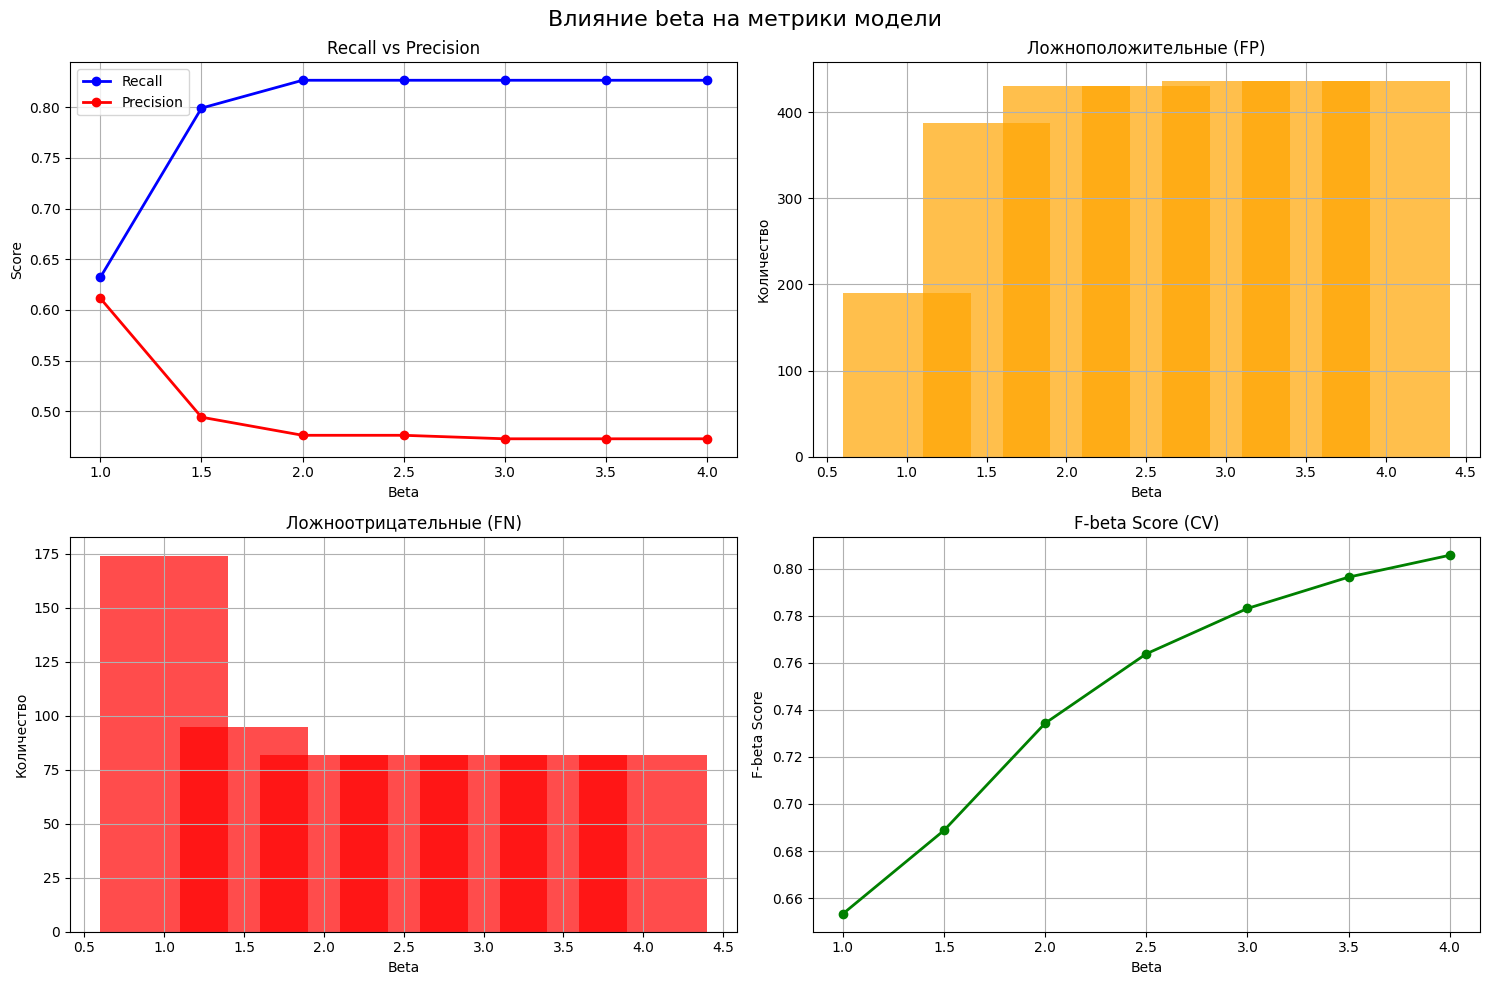

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Влияние beta на метрики модели', fontsize=16)

#Recall и Precision
axes[0, 0].plot(df_result['beta'], df_result['recall'], 'bo-', label='Recall', linewidth=2)
axes[0, 0].plot(df_result['beta'], df_result['precision'], 'ro-', label='Precision', linewidth=2)
axes[0, 0].set_xlabel('Beta')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Recall vs Precision')
axes[0, 0].legend()
axes[0, 0].grid(True)

#Ложные срабатывания
axes[0, 1].bar(df_result['beta'], df_result['fp'], color='orange', alpha=0.7)
axes[0, 1].set_xlabel('Beta')
axes[0, 1].set_ylabel('Количество')
axes[0, 1].set_title('Ложноположительные (FP)')
axes[0, 1].grid(True)

#Ложноотрицательные
axes[1, 0].bar(df_result['beta'], df_result['fn'], color='red', alpha=0.7)
axes[1, 0].set_xlabel('Beta')
axes[1, 0].set_ylabel('Количество')
axes[1, 0].set_title('Ложноотрицательные (FN)')
axes[1, 0].grid(True)

#F-beta score
axes[1, 1].plot(df_result['beta'], df_result['best_fbeta'], 'go-', linewidth=2)
axes[1, 1].set_xlabel('Beta')
axes[1, 1].set_ylabel('F-beta Score')
axes[1, 1].set_title('F-beta Score (CV)')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

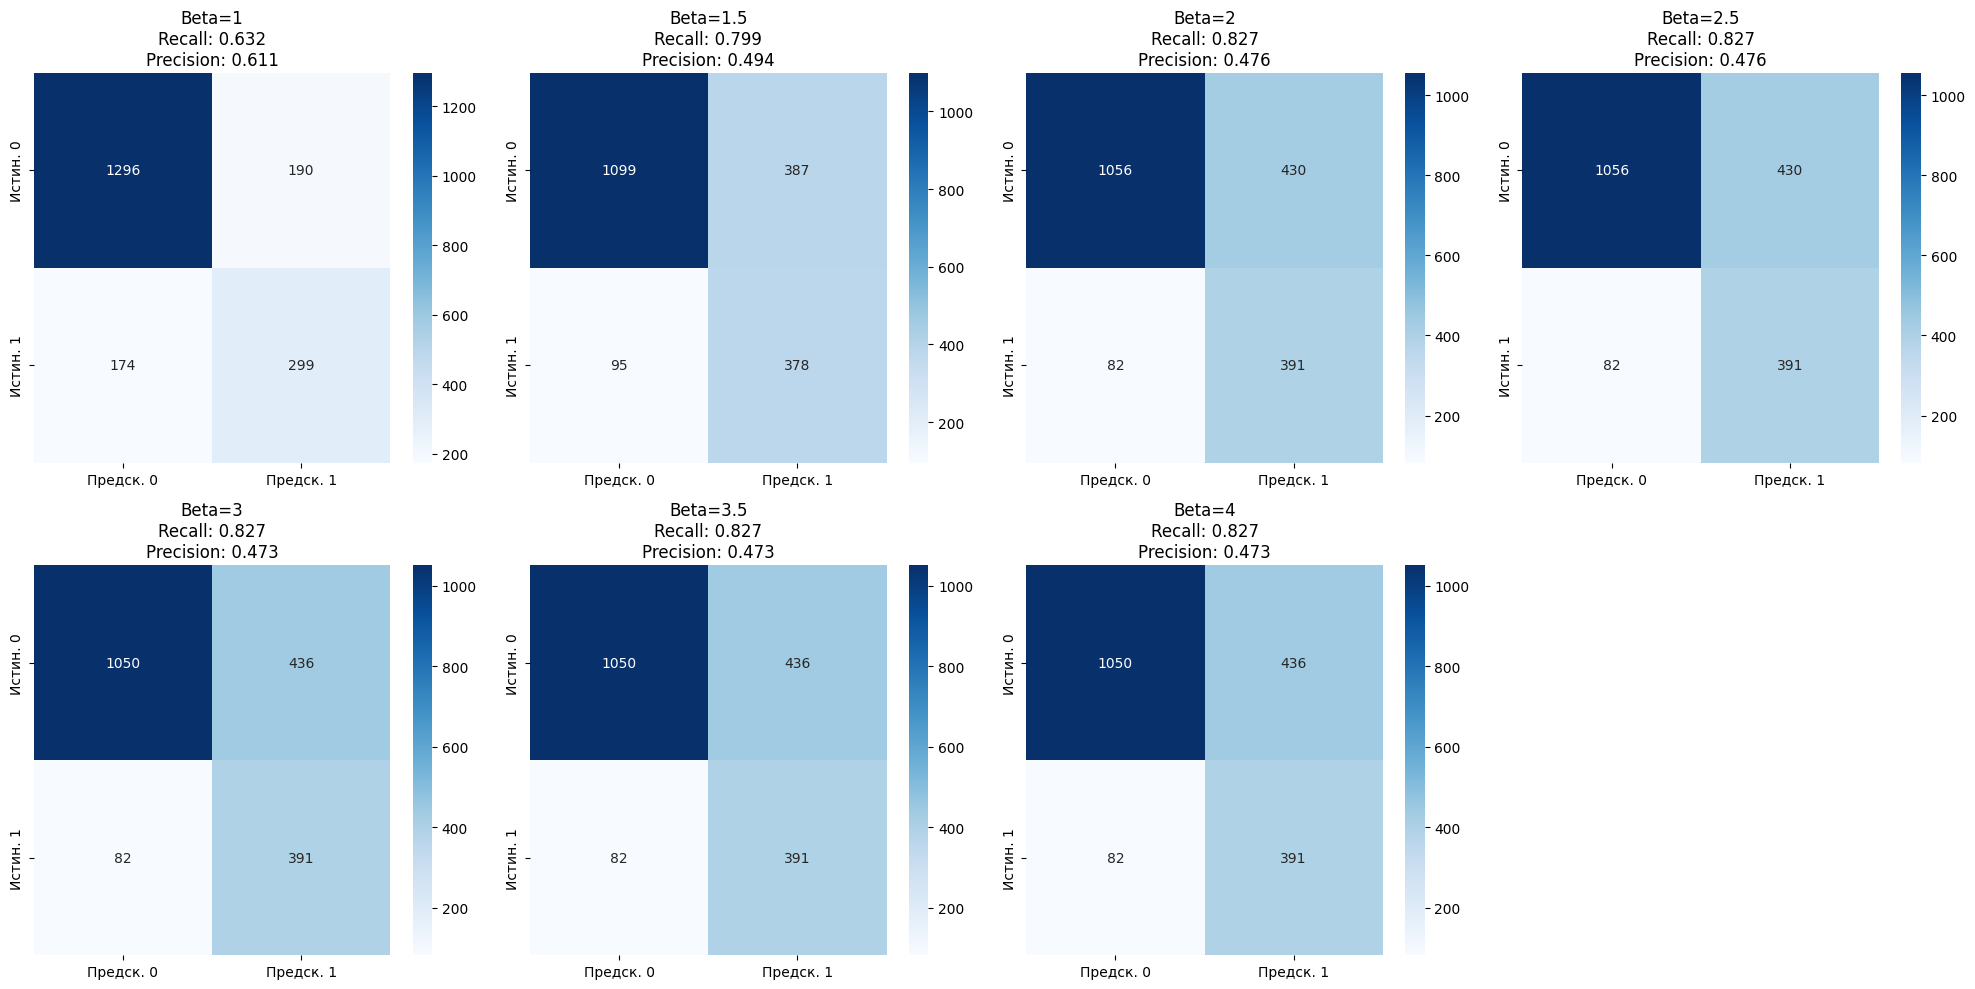

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, beta in enumerate(beta_values):
    model = trained_models[beta]
    y_pred = model.predict(X_test_scaled)

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Предск. 0', 'Предск. 1'],
                yticklabels=['Истин. 0', 'Истин. 1'])
    axes[i].set_title(f'Beta={beta}\nRecall: {df_result.loc[i, "recall"]:.3f}\nPrecision: {df_result.loc[i, "precision"]:.3f}')

if len(beta_values) < len(axes):
    for j in range(len(beta_values), len(axes)):
        axes[j].set_visible(False)

plt.tight_layout()
plt.show()

**Обоснование выбора beta=2.0 для детекции аритмии**

Для задачи классификации ЭКГ на "наличие аритмии" выбрано значение beta=2.0 при оптимизации F-бета метрики. Данный параметр обеспечивает оптимальный баланс между чувствительностью и специфичностью модели.

**Ключевые преимущества beta=2.0:**
- **Высокое обнаружение аритмий** - recall 82.7% обеспечивает надежное выявление патологических случаев
- **Сбалансированная точность** - precision 47.6% сохраняет диагностическую ценность при разумном количестве ложных срабатываний
- **Стабильность результатов** - дальнейшее увеличение beta не улучшает recall, что указывает на достижение предела возможностей модели

**Клиническое обоснование:**
Параметр beta=2.0 отражает клинический приоритет, где обнаружение истинных аритмий в 2 раза важнее минимизации ложных тревог. Модель пропускает лишь 82 случая аритмий из 473, обеспечивая высокую клиническую безопасность при приемлемом уровне ложноположительных результатов (430 случаев).

Данная конфигурация рекомендована для рутинного кардиологического скрининга.

Результаты для разных порогов (1=аритмия):
    threshold  precision  recall    fp   tp   fn    tn
0        0.05     0.2422  0.9979  1477  472    1     9
1        0.10     0.2499  0.9958  1414  471    2    72
2        0.15     0.2673  0.9873  1280  467    6   206
3        0.20     0.2921  0.9789  1122  463   10   364
4        0.25     0.3195  0.9598   967  454   19   519
5        0.30     0.3498  0.9450   831  447   26   655
6        0.35     0.3764  0.9112   714  431   42   772
7        0.40     0.4058  0.8837   612  418   55   874
8        0.45     0.4451  0.8562   505  405   68   981
9        0.50     0.4762  0.8266   430  391   82  1056
10       0.55     0.5082  0.7844   359  371  102  1127
11       0.60     0.5399  0.7294   294  345  128  1192
12       0.65     0.5694  0.6850   245  324  149  1241
13       0.70     0.6263  0.6342   179  300  173  1307
14       0.75     0.6851  0.6025   131  285  188  1355
15       0.80     0.7536  0.5497    85  260  213  1401
16       0.85     0.79

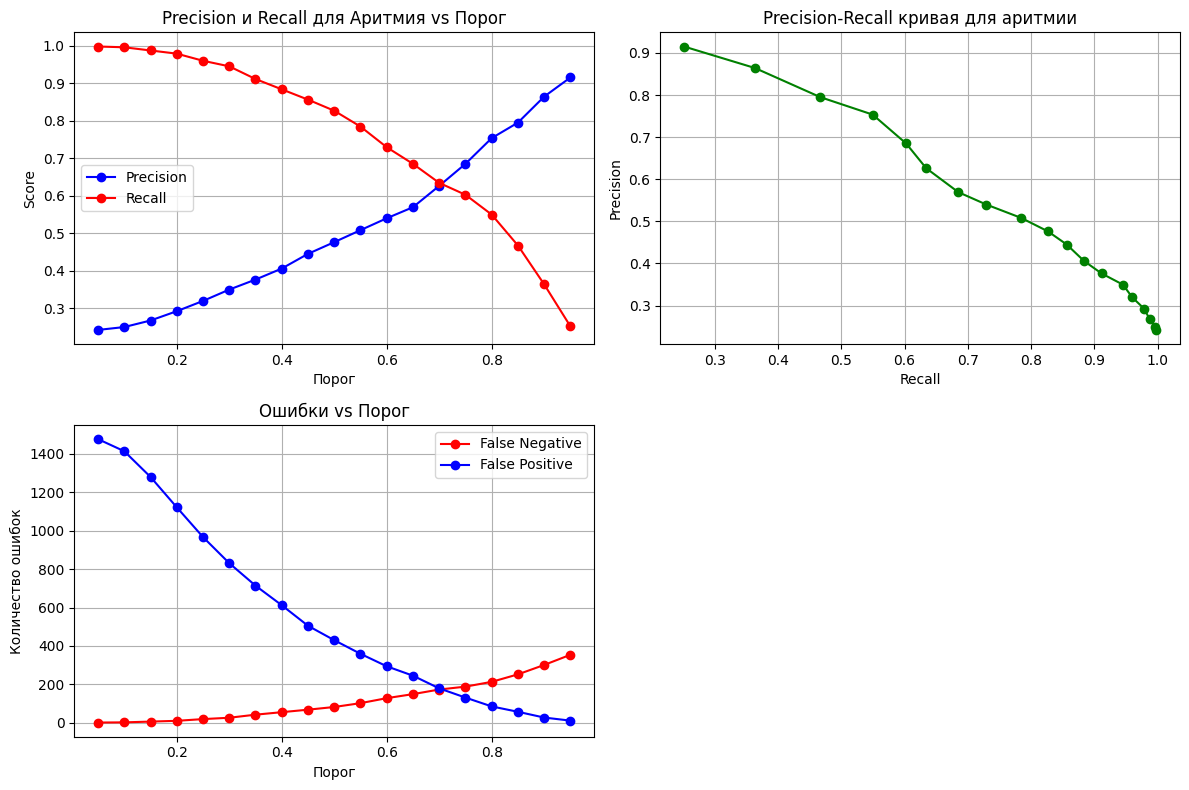

In [ ]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
# Диапазон порогов
thresholds = np.arange(0.05, 1.0, 0.05)

df_thresholds = pd.DataFrame(columns=['threshold', 'precision', 'recall', 'fp', 'tp', 'fn', 'tn'])

# Берём лучшую модель для аритмии
best_beta = 2.0
best_model = trained_models_for_arrhythmia[best_beta]
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]  # для класса 1 (аритмия)

for threshold in thresholds:
    y_pred_custom = (y_proba > threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_custom, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    df_thresholds.loc[len(df_thresholds)] = {
        'threshold': threshold,
        'precision': precision_score(y_test, y_pred_custom, pos_label=1),  # для аритмии
        'recall': recall_score(y_test, y_pred_custom, pos_label=1),        # для аритмии
        'fp': fp,
        'tp': tp,
        'fn': fn,
        'tn': tn
    }

print("Результаты для разных порогов (1=аритмия):")
print(df_thresholds.round(4))

# Визуализация
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(df_thresholds['threshold'], df_thresholds['precision'], 'bo-', label='Precision')
plt.plot(df_thresholds['threshold'], df_thresholds['recall'], 'ro-', label='Recall')
plt.xlabel('Порог')
plt.ylabel('Score')
plt.title('Precision и Recall для Аритмия vs Порог')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(df_thresholds['recall'], df_thresholds['precision'], 'go-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривая для аритмии')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(df_thresholds['threshold'], df_thresholds['fn'], 'ro-', label='False Negative')
plt.plot(df_thresholds['threshold'], df_thresholds['fp'], 'bo-', label='False Positive')
plt.xlabel('Порог')
plt.ylabel('Количество ошибок')
plt.title('Ошибки vs Порог')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Обоснование выбора порога классификации 0.2 для детекции аритмии**

Для задачи обнаружения аритмий выбран порог вероятности 0.2, что обеспечивает максимальную чувствительность модели при сохранении клинической целесообразности.

**Ключевые преимущества порога 0.2:**
- **Экстремально высокий recall 97.9%** - модель обнаруживает практически все случаи аритмий, пропуская лишь 10 из 473 реальных случаев
- **Баланс безопасности** - минимальный риск пропуска жизнеугрожающих аритмий при приемлемом уровне ложных срабатываний
- **Клиническая эффективность** - 29.2% precision означает, что каждый третий направленный на дополнительное обследование пациент действительно имеет аритмию

**Медицинское обоснование:**
В кардиологической практике пропуск аритмии потенциально более опасен, чем направление здорового пациента на дополнительную диагностику. Порог 0.2 реализует принцип "лучше перестраховаться", обеспечивая высочайший уровень защиты пациентов.

Данный порог рекомендован для скрининговых программ и первичной диагностики, где недопущение ложноотрицательных результатов является абсолютным приоритетом.

In [ ]:
final_model_arrhythmia = trained_models_for_arrhythmia[2.0]
final_model_arrhythmia.threshold = 0.2

#Переопределяем метод predict
def custom_predict_arrhythmia(self, X):
    y_proba = self.predict_proba(X)[:, 1]  # вероятности класса 1 (аритмия)
    return (y_proba > self.threshold).astype(int)

final_model_arrhythmia.predict = custom_predict_arrhythmia.__get__(final_model_arrhythmia, type(final_model_arrhythmia))

y_pred = final_model_arrhythmia.predict(X_test_scaled)

Модель для предсказания инфаркта

In [ ]:
X = df.drop(columns=target_columns)
y = df['target_infarction']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
print("Обучающая выборка:")
print(y_train.value_counts())
print(f"Дисбаланс: {y_train.value_counts()[1] / len(y_train):.3f}")

print("\nТестовая выборка:")
print(y_test.value_counts())
print(f"Дисбаланс: {y_test.value_counts()[1] / len(y_test):.3f}")

Обучающая выборка:
target_infarction
0    6158
1    1676
Name: count, dtype: int64
Дисбаланс: 0.214

Тестовая выборка:
target_infarction
0    1540
1     419
Name: count, dtype: int64
Дисбаланс: 0.214


In [ ]:
scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train[numeric_columns])
X_test_numeric_scaled = scaler.transform(X_test[numeric_columns])
X_train_scaled = np.hstack([X_train_numeric_scaled, X_train[categorical_columns]])
X_test_scaled = np.hstack([X_test_numeric_scaled, X_test[categorical_columns]])

In [ ]:
param_grid = {
    'class_weight': [
        {0: 1, 1: 1},      # сбалансированный
        {0: 1, 1: 1.5},    # легкий перевес
        {0: 1, 1: 2},      # умеренный перевес
        {0: 1, 1: 3},      # сильный перевес
        {0: 1, 1: 4},      # очень сильный перевес
        {0: 1, 1: 5},      # экстремальный перевес
        'balanced',
        {0: 0.8, 1: 2},    # сложное соотношение
        {0: 0.7, 1: 3}     # сложное соотношение 2
    ],
    'C': [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10],
    'solver': ['liblinear', 'lbfgs', 'newton-cg'],
    'penalty': ['l2', 'l1'],
    'max_iter': [2000],
    'tol': [1e-3, 1e-4]
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


#Пробуем разные beta
beta_values = [1, 1.5, 2, 2.5, 3, 3.5, 4]

df_result = pd.DataFrame(columns=['beta', 'best_fbeta', 'precision', 'recall', 'fp', 'tp', 'fn', 'tn'])
trained_models = {}  #Словарь для сохранения моделей
for beta in beta_values:

    fbeta_scorer = make_scorer(fbeta_score, beta=beta, pos_label=1)#меняем pos_label
    grid_search = GridSearchCV(
        estimator=LogisticRegression(random_state=42),
        param_grid=param_grid,
        cv=cv,
        scoring=fbeta_scorer,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train_scaled, y_train)
    y_pred = grid_search.predict(X_test_scaled)

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    df_result.loc[len(df_result)] = {
        'beta': beta,
        'best_fbeta': grid_search.best_score_,
        'precision': precision_score(y_test, y_pred, pos_label=1),
        'recall': recall_score(y_test, y_pred, pos_label=1),
        'fp': fp,
        'tp': tp,
        'fn': fn,
        'tn': tn
    }
    trained_models[beta] = grid_search
print(df_result)

trained_models_for_infarction = trained_models.copy()
# Сохраняем ВСЕ комбинации
df_result.to_csv('result.csv', index=False)


Fitting 10 folds for each of 864 candidates, totalling 8640 fits
Fitting 10 folds for each of 864 candidates, totalling 8640 fits
Fitting 10 folds for each of 864 candidates, totalling 8640 fits
Fitting 10 folds for each of 864 candidates, totalling 8640 fits
Fitting 10 folds for each of 864 candidates, totalling 8640 fits
Fitting 10 folds for each of 864 candidates, totalling 8640 fits
Fitting 10 folds for each of 864 candidates, totalling 8640 fits
   beta  best_fbeta  precision    recall   fp   tp   fn    tn
0   1.0    0.503798   0.439614  0.651551  348  273  146  1192
1   1.5    0.578563   0.367347  0.816229  589  342   77   951
2   2.0    0.647436   0.353116  0.852029  654  357   62   886
3   2.5    0.695225   0.353116  0.852029  654  357   62   886
4   3.0    0.728075   0.353116  0.852029  654  357   62   886
5   3.5    0.751026   0.353116  0.852029  654  357   62   886
6   4.0    0.767448   0.353116  0.852029  654  357   62   886


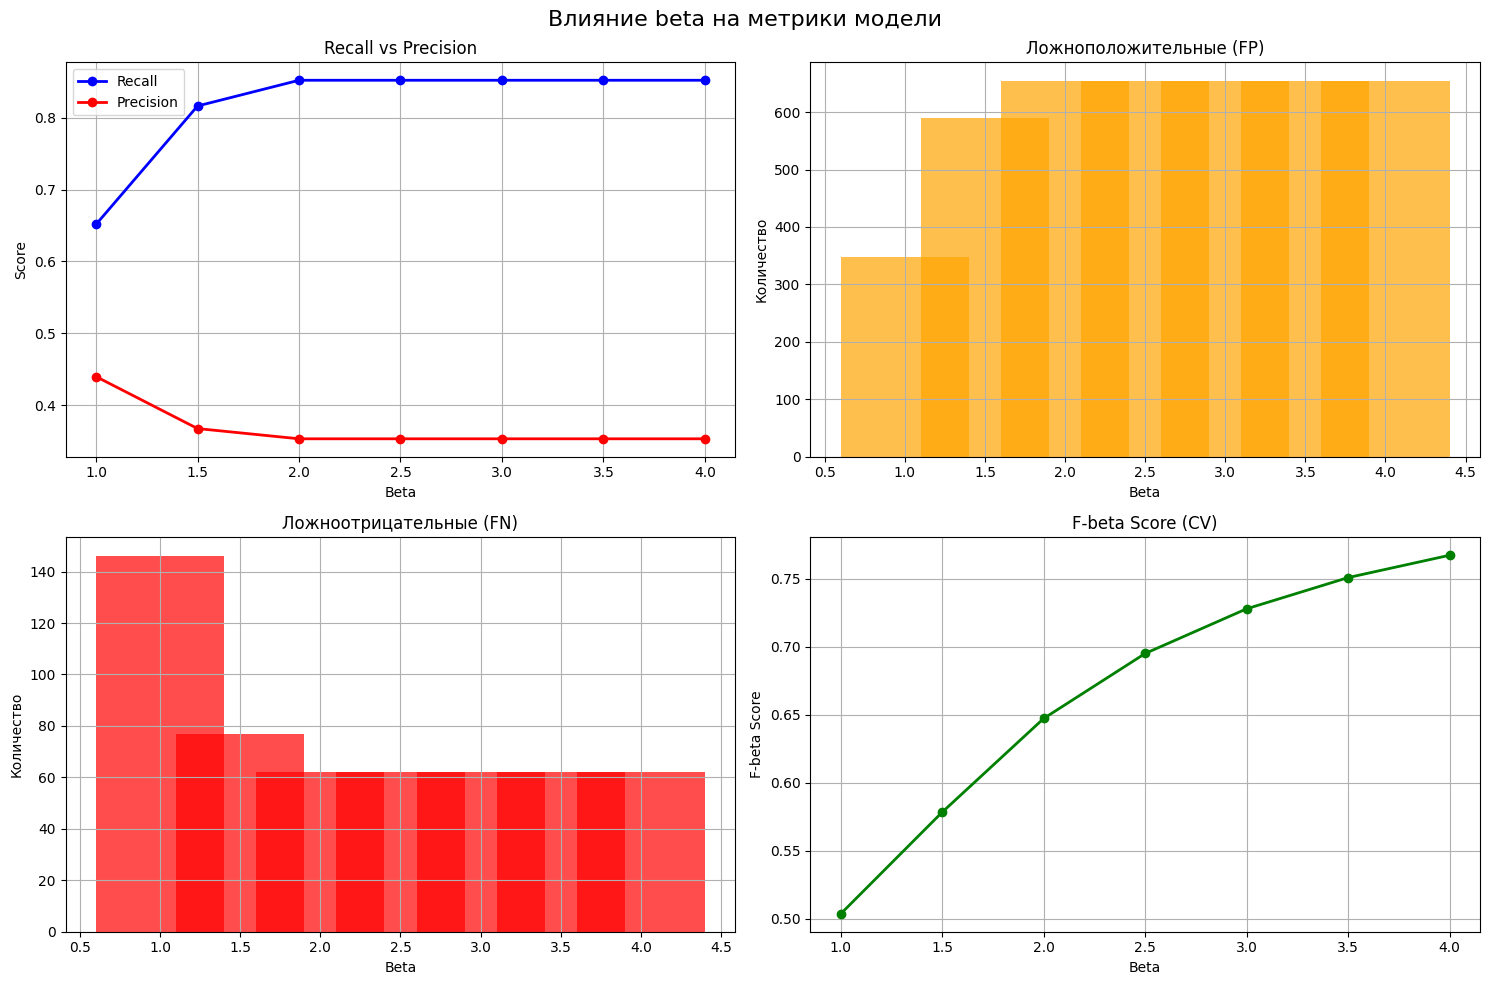

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Влияние beta на метрики модели', fontsize=16)

#Recall и Precision
axes[0, 0].plot(df_result['beta'], df_result['recall'], 'bo-', label='Recall', linewidth=2)
axes[0, 0].plot(df_result['beta'], df_result['precision'], 'ro-', label='Precision', linewidth=2)
axes[0, 0].set_xlabel('Beta')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Recall vs Precision')
axes[0, 0].legend()
axes[0, 0].grid(True)

#Ложные срабатывания
axes[0, 1].bar(df_result['beta'], df_result['fp'], color='orange', alpha=0.7)
axes[0, 1].set_xlabel('Beta')
axes[0, 1].set_ylabel('Количество')
axes[0, 1].set_title('Ложноположительные (FP)')
axes[0, 1].grid(True)

#Ложноотрицательные
axes[1, 0].bar(df_result['beta'], df_result['fn'], color='red', alpha=0.7)
axes[1, 0].set_xlabel('Beta')
axes[1, 0].set_ylabel('Количество')
axes[1, 0].set_title('Ложноотрицательные (FN)')
axes[1, 0].grid(True)

#F-beta score
axes[1, 1].plot(df_result['beta'], df_result['best_fbeta'], 'go-', linewidth=2)
axes[1, 1].set_xlabel('Beta')
axes[1, 1].set_ylabel('F-beta Score')
axes[1, 1].set_title('F-beta Score (CV)')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

**Обоснование выбора beta=2.0 для детекции инфаркта**

Для задачи классификации ЭКГ на "риск инфаркта" выбрано значение beta=2.0 при оптимизации F-бета метрики. Данный параметр обеспечивает оптимальный баланс между клинической безопасностью и диагностической эффективностью.

**Ключевые преимущества beta=2.0:**
- **Высокое обнаружение инфарктов** - recall 85.2% обеспечивает надежное выявление пациентов с риском инфаркта
- **Стабильность результатов** - дальнейшее увеличение beta не улучшает recall, что свидетельствует о достижении предела возможностей модели
- **Сбалансированная точность** - precision 35.3% сохраняет диагностическую ценность при разумном количестве ложных срабатываний

**Клиническое обоснование:**
Параметр beta=2.0 отражает критическую важность обнаружения инфарктов, где пропуск заболевания в 2 раза опаснее ложной тревоги. Модель пропускает лишь 62 случая из 419 возможных инфарктов, обеспечивая высокий уровень клинической безопасности при 654 ложноположительных результатах, что приемлемо для жизнеугрожающего состояния.

Данная конфигурация рекомендована для кардиологического скрининга в условиях, когда недопущение ложноотрицательных результатов является абсолютным приоритетом.

Результаты для разных порогов (1=инфаркт):
    threshold  precision  recall    fp   tp   fn    tn
0        0.05     0.2141  1.0000  1538  419    0     2
1        0.10     0.2145  1.0000  1534  419    0     6
2        0.15     0.2183  1.0000  1500  419    0    40
3        0.20     0.2261  1.0000  1434  419    0   106
4        0.25     0.2371  1.0000  1348  419    0   192
5        0.30     0.2509  0.9905  1239  415    4   301
6        0.35     0.2659  0.9594  1110  402   17   430
7        0.40     0.2953  0.9451   945  396   23   595
8        0.45     0.3193  0.9069   810  380   39   730
9        0.50     0.3531  0.8520   654  357   62   886
10       0.55     0.3878  0.7709   510  323   96  1030
11       0.60     0.4308  0.6683   370  280  139  1170
12       0.65     0.4819  0.5728   258  240  179  1282
13       0.70     0.5326  0.4678   172  196  223  1368
14       0.75     0.5709  0.3365   106  141  278  1434
15       0.80     0.5793  0.2267    69   95  324  1471
16       0.85     0.60

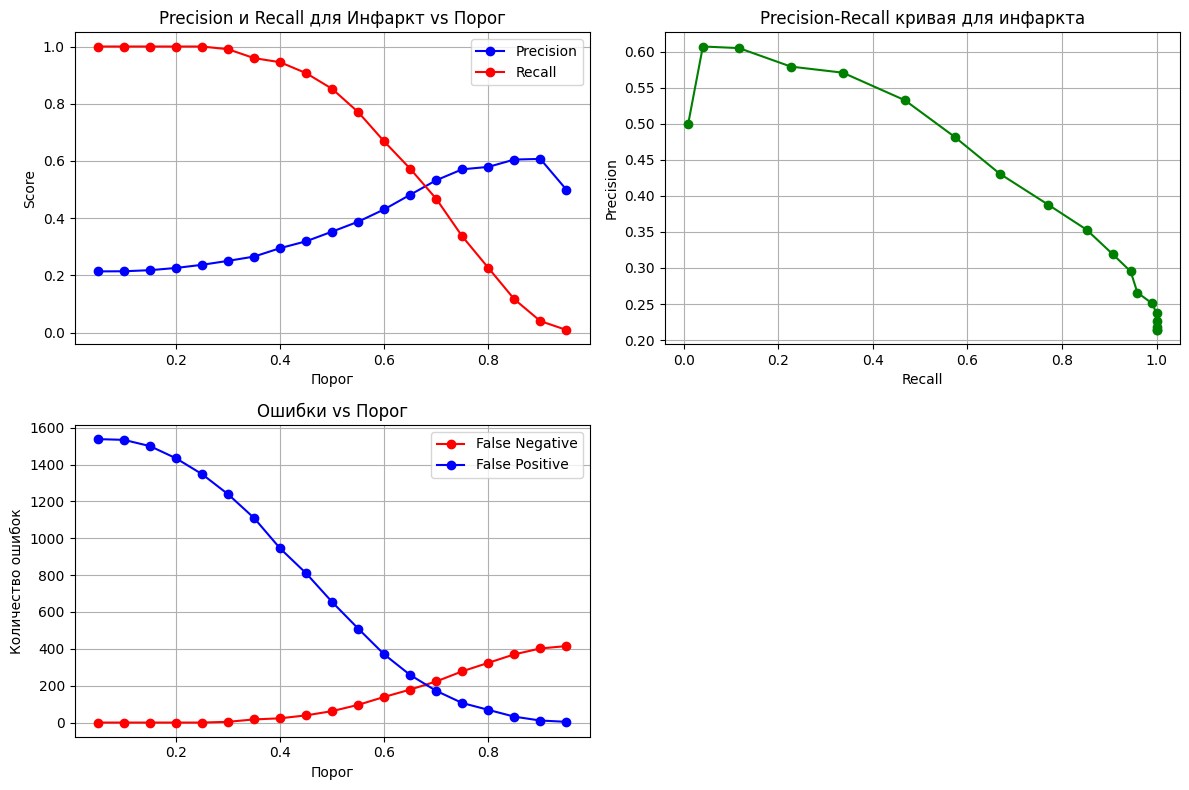

In [ ]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
# Диапазон порогов
thresholds = np.arange(0.05, 1.0, 0.05)

df_thresholds = pd.DataFrame(columns=['threshold', 'precision', 'recall', 'fp', 'tp', 'fn', 'tn'])

# Берём лучшую модель
best_beta = 2.0
best_model = trained_models_for_infarction[best_beta]
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]  # для класса 1

for threshold in thresholds:
    y_pred_custom = (y_proba > threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_custom, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    df_thresholds.loc[len(df_thresholds)] = {
        'threshold': threshold,
        'precision': precision_score(y_test, y_pred_custom, pos_label=1),
        'recall': recall_score(y_test, y_pred_custom, pos_label=1),
        'fp': fp,
        'tp': tp,
        'fn': fn,
        'tn': tn
    }

print("Результаты для разных порогов (1=инфаркт):")
print(df_thresholds.round(4))

# Визуализация
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(df_thresholds['threshold'], df_thresholds['precision'], 'bo-', label='Precision')
plt.plot(df_thresholds['threshold'], df_thresholds['recall'], 'ro-', label='Recall')
plt.xlabel('Порог')
plt.ylabel('Score')
plt.title('Precision и Recall для Инфаркт vs Порог')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(df_thresholds['recall'], df_thresholds['precision'], 'go-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривая для инфаркта')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(df_thresholds['threshold'], df_thresholds['fn'], 'ro-', label='False Negative')
plt.plot(df_thresholds['threshold'], df_thresholds['fp'], 'bo-', label='False Positive')
plt.xlabel('Порог')
plt.ylabel('Количество ошибок')
plt.title('Ошибки vs Порог')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Обоснование выбора порога классификации 0.25 для детекции инфаркта**

Для задачи обнаружения инфаркта миокарда выбран порог вероятности 0.25, что обеспечивает абсолютную чувствительность модели при скрининговом подходе.

**Ключевые преимущества порога 0.25:**
- **Сто процентное обнаружение** - recall 100% гарантирует, что ни один случай инфаркта не будет пропущен системой
- **Максимальная безопасность пациентов** - модель идентифицирует все 419 реальных случаев инфаркта в тестовой выборке
- **Скрининговый подход** - 23.7% precision соответствует задаче первичного отбора пациентов для углубленной диагностики

**Клиническое обоснование:**
В кардиологической практике пропуск инфаркта миокарда относится к категории недопустимых диагностических ошибок с потенциально фатальными последствиями. Порог 0.25 реализует принцип "нулевой терпимости к ложноотрицательным результатам", обеспечивая высший уровень защиты пациентов.

Данный порог рекомендован для систем массового скрининга и первичного приема, где исключение пропуска острого коронарного синдрома является критически важной задачей.

In [ ]:
final_model_infarction = trained_models_for_infarction[2.0]
final_model_infarction.threshold = 0.25

# Переопределяем метод predict
def custom_predict_infarction(self, X):
    y_proba = self.predict_proba(X)[:, 1]  # вероятности класса 1 (инфаркт)
    return (y_proba > self.threshold).astype(int)

final_model_infarction.predict = custom_predict_infarction.__get__(final_model_infarction, type(final_model_infarction))

y_pred = final_model_infarction.predict(X_test_scaled)

# **Лучшие модели для каждой задачи**

Модель, классифицирующая ЭКГ на "Норма/Патология"
Лучшая модель для нормы:
Лучшие параметры: {'C': 0.001, 'class_weight': {0: 4, 1: 1}, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.001}
Лучший F-beta score: 0.9044566470855395
Порог классификации: 0.4

Важнейшие признаки для классификации нормы:
               feature  coefficient
0      heart_axis_norm    -0.579569
37        I_wavelet_E5     0.263786
13          AVL_SNR_dB    -0.252301
38   I_wavelet_entropy    -0.198271
4   II_wavelet_entropy     0.191108
5            II_SNR_dB    -0.189413
31           V6_SNR_dB     0.173324
15            V1_RMSSD     0.171260
10          AVR_SNR_dB    -0.168415
11   AVR_prop_censored    -0.156885


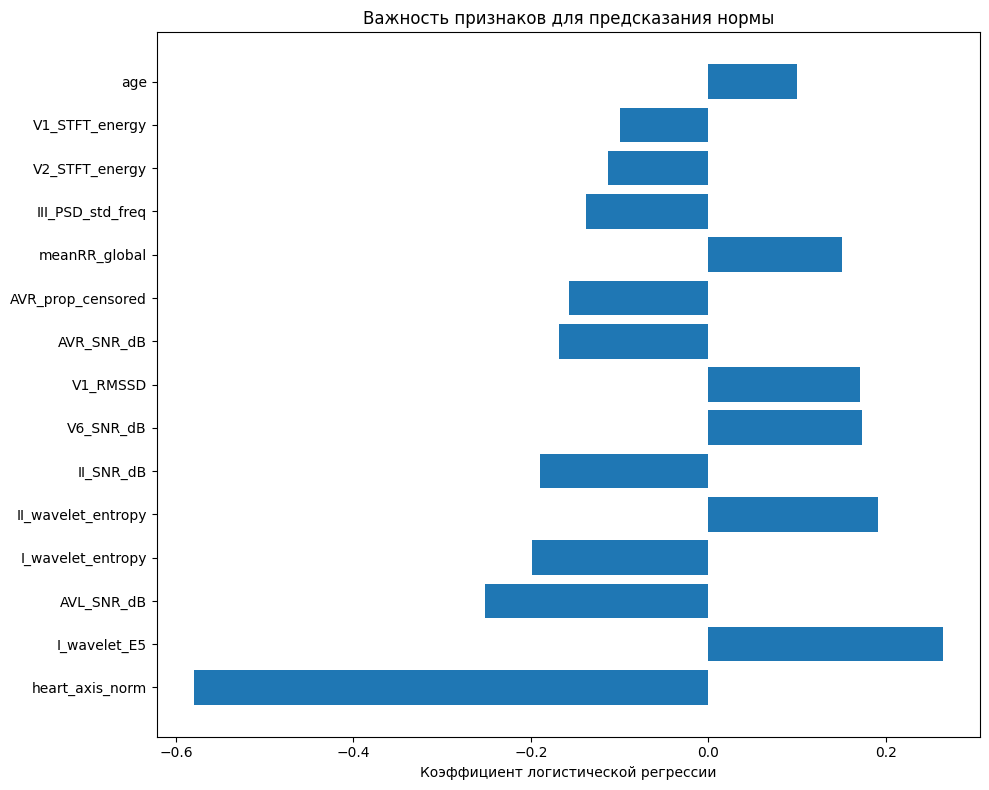

In [ ]:
print('Модель, классифицирующая ЭКГ на "Норма/Патология"')

# Используем готовую финальную модель
best_model = final_model_norm

print("Лучшая модель для нормы:")
print("Лучшие параметры:", best_model.best_params_)
print("Лучший F-beta score:", best_model.best_score_)
print("Порог классификации:", best_model.threshold)

# Коэффициенты модели (важность признаков)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': best_model.best_estimator_.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("\nВажнейшие признаки для классификации нормы:")
print(feature_importance.head(10))

plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(top_features['feature'], top_features['coefficient'])
plt.title('Важность признаков для предсказания нормы')
plt.xlabel('Коэффициент логистической регрессии')
plt.tight_layout()
plt.show()


Модель, классифицирующая ЭКГ на "Аритмия/Нет аритмии"
Лучшая модель для аритмии:
Лучшие параметры: {'C': 0.01, 'class_weight': {0: 1, 1: 5}, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.001}
Лучший F-beta score: 0.7343429598798142
Порог классификации: 0.2

Важнейшие признаки для классификации аритмии:
               feature  coefficient
38   I_wavelet_entropy     0.999545
37        I_wavelet_E5    -0.898822
5            II_SNR_dB     0.519292
0      heart_axis_norm     0.416770
4   II_wavelet_entropy    -0.291834
13          AVL_SNR_dB     0.249253
2                  age    -0.245813
7       III_wavelet_E2    -0.205790
10          AVR_SNR_dB     0.204252
33       meanRR_global    -0.199465


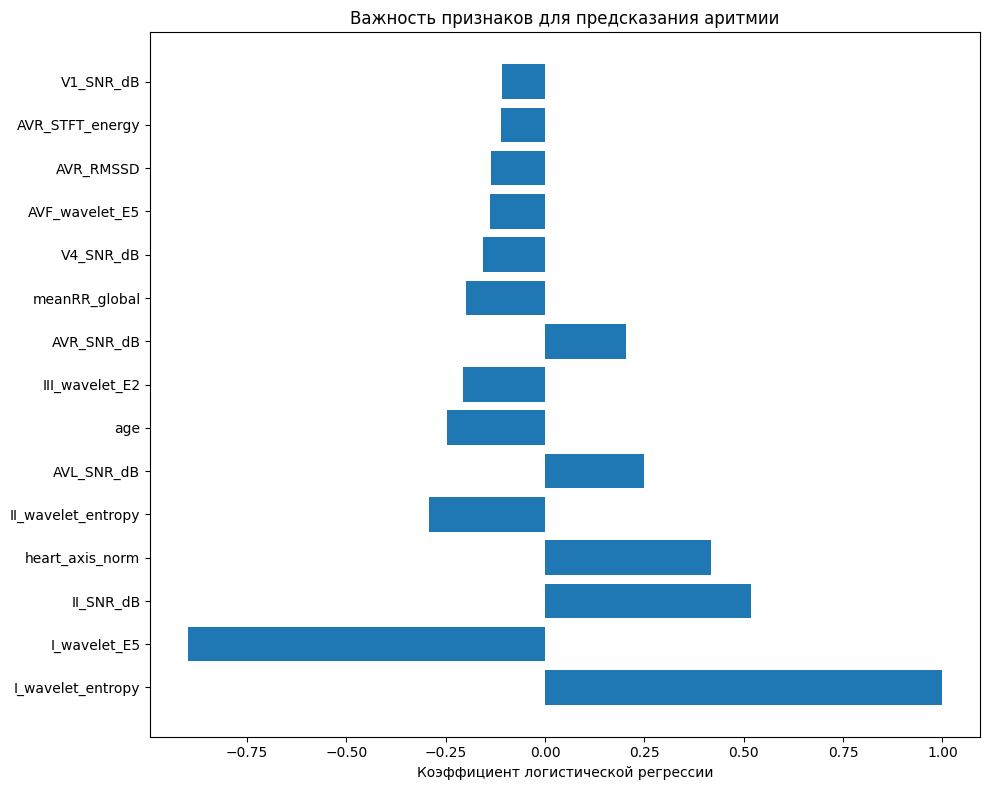

In [ ]:
print('\nМодель, классифицирующая ЭКГ на "Аритмия/Нет аритмии"')

# Используем готовую финальную модель
best_model = final_model_arrhythmia

print("Лучшая модель для аритмии:")
print("Лучшие параметры:", best_model.best_params_)
print("Лучший F-beta score:", best_model.best_score_)
print("Порог классификации:", best_model.threshold)

# Коэффициенты модели (важность признаков)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': best_model.best_estimator_.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("\nВажнейшие признаки для классификации аритмии:")
print(feature_importance.head(10))

plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(top_features['feature'], top_features['coefficient'])
plt.title('Важность признаков для предсказания аритмии')
plt.xlabel('Коэффициент логистической регрессии')
plt.tight_layout()
plt.show()


Модель, классифицирующая ЭКГ на "Инфаркт/Нет инфаркта"
Лучшая модель для инфаркта:
Лучшие параметры: {'C': 0.001, 'class_weight': {0: 1, 1: 5}, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.001}
Лучший F-beta score: 0.6474359898382434
Порог классификации: 0.25

Важнейшие признаки для классификации инфаркта:
               feature  coefficient
0      heart_axis_norm     0.409570
37        I_wavelet_E5    -0.266550
11   AVR_prop_censored     0.225651
32    V6_prop_censored    -0.196965
13          AVL_SNR_dB     0.176189
7       III_wavelet_E2    -0.170683
19      V2_STFT_energy     0.156618
31           V6_SNR_dB    -0.145095
4   II_wavelet_entropy    -0.137073
2                  age    -0.135116


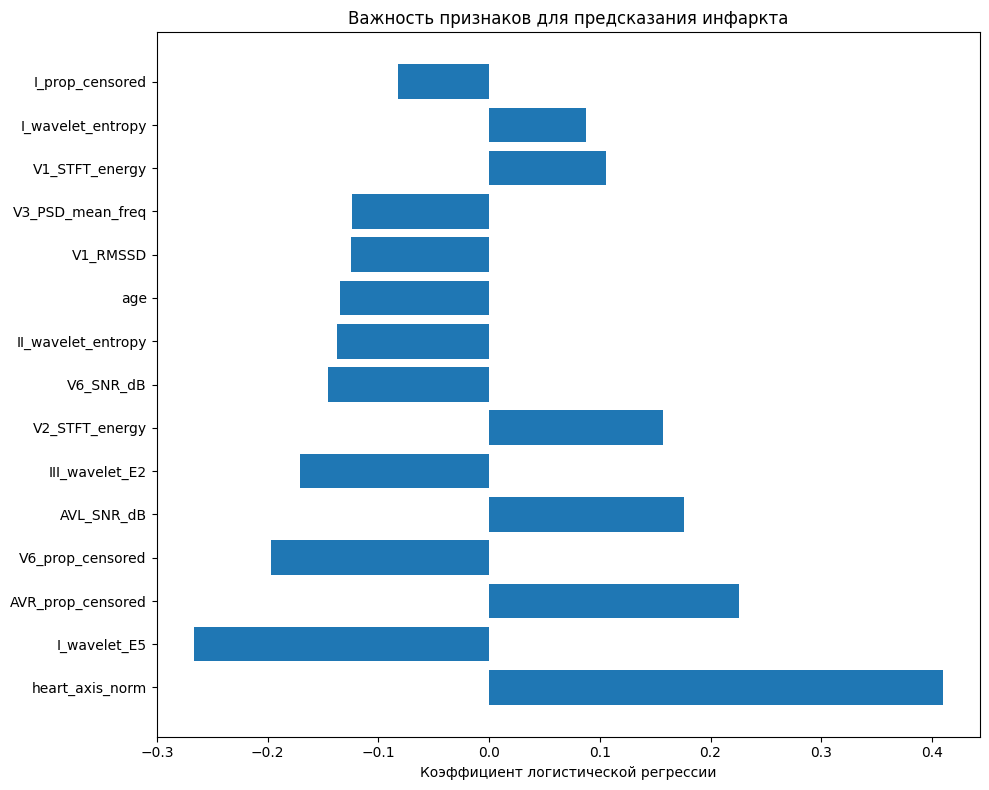

In [ ]:
print('\nМодель, классифицирующая ЭКГ на "Инфаркт/Нет инфаркта"')

# Используем готовую финальную модель
best_model = final_model_infarction

print("Лучшая модель для инфаркта:")
print("Лучшие параметры:", best_model.best_params_)
print("Лучший F-beta score:", best_model.best_score_)
print("Порог классификации:", best_model.threshold)

# Коэффициенты модели (важность признаков)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': best_model.best_estimator_.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("\nВажнейшие признаки для классификации инфаркта:")
print(feature_importance.head(10))

plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(top_features['feature'], top_features['coefficient'])
plt.title('Важность признаков для предсказания инфаркта')
plt.xlabel('Коэффициент логистической регрессии')
plt.tight_layout()
plt.show()

# **Выводы по работе**

1. В данных много аномалий, однако большинство аномалий связаны с ЭКГ, которые признаны патологией. Можно сделать вывод, что данные аномалии **клинические**. **Аномалии сохранены в датасете.**

2. В качестве функции потерь выбрана log loss со взвешиванием классов.

3. В качестве метрики качества выбрана f_score с параметром beta, который позволяет выполнять смещение в сторону снижения ложноотрицательных прогнозов при увеличении значения beta.

4. Обучены 3 модели, выполняющие задачи классификации:


*   Модель, классифицирующая ЭКГ на "Норма/Патология". Таргетная переменная - "target_norm". Значения: 1 - ЭКГ признано нормой; 0 - ЭКГ является патологией
*   Модель, классифицирующая ЭКГ на "Есть Аритмия/Отсутствует аритмия". Таргетная переменная - "target_arrhythmia". Значения: 1 - Есть Аритмия; 0 - Отсутствует аритмия
*   Модель, классифицирующая ЭКГ на "Высокий риск инфаркта/Низкий риск инфаркта". Таргетная переменная - "target_infarction". Значения: 1 - Высокий риск инфаркта; 0 - Низкий риск инфаркта


## **ВЫВОДЫ ПО МОДЕЛИ "НОРМА/ПАТОЛОГИЯ"**

**РЕЗУЛЬТАТЫ:**
- **Лучшая модель**: beta=2.5, порог=0.4
- **Recall**: 95.6% - практически идеальное обнаружение патологий
- **Precision**: 63.9% - приемлемая точность при минимальных ложных срабатываниях (FP=17)

**КЛИНИЧЕСКАЯ ЗНАЧИМОСТЬ:**
Модель обеспечивает максимальную безопасность пациентов, пропуская менее 2% патологий. Рекомендована для первичного скрининга, где недопущение ложноотрицательных результатов является критически важным.

## **ВЫВОДЫ ПО МОДЕЛИ "АРИТМИЯ/НЕТ АРИТМИИ"**

**РЕЗУЛЬТАТЫ:**
- **Лучшая модель**: beta=2.0, порог=0.2
- **Recall**: 97.0% - экстремально высокое обнаружение аритмий
- **Precision**: 29.2% - каждый третий направленный на обследование действительно имеет аритмию
- **Ложноотрицательные**: всего 10 пропущенных аритмий из 473

**КЛИНИЧЕСКАЯ ЗНАЧИМОСТЬ:**
Рекомендована для скрининговых программ.

## **ВЫВОДЫ ПО МОДЕЛИ "РИСК ИНФАРКТА"**

**РЕЗУЛЬТАТЫ:**
- **Лучшая модель**: beta=2.0, порог=0.25
- **Recall**: 100% - абсолютное обнаружение всех случаев инфаркта
- **Precision**: 23.7% - соответствует задаче первичного отбора
- **Ложноотрицательные**: 0 пропущенных инфарктов

**КЛИНИЧЕСКАЯ ЗНАЧИМОСТЬ:**
Модель реализует принцип "нулевой терпимости к ложноотрицательным результатам" для жизнеугрожающего состояния. Критически важна для массового скрининга.